Step 1: Install Required Libraries

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import efficientnet_b0
from ptflops import get_model_complexity_info
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

Step 2: Device & Imports

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("results", exist_ok=True)

In [26]:
def get_cifar10_loaders(resolution=224, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
    ])
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Step 4: Define base & scaled Models(Depth, Width, Compound)

In [27]:
def get_base_model(num_classes=10):
    model = efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

def depth_only_model(scale=1.2, num_classes=10):
    model = get_base_model(num_classes)
    import copy
    new_blocks = []
    for block in model.features:
        new_blocks.append(block)
        if block.__class__.__name__.startswith("MBConv"):
            new_blocks.append(copy.deepcopy(block))
    model.features = nn.Sequential(*new_blocks)
    return model.to(device)

def width_only_model(scale=1.1, num_classes=10):
    model = get_base_model(num_classes)
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.out_channels = int(m.out_channels * scale)
    return model.to(device)

def compound_model(scale_d=1.2, scale_w=1.1, num_classes=10):
    model = depth_only_model(scale=scale_d, num_classes=num_classes)
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.out_channels = int(m.out_channels * scale_w)
    return model.to(device)

Step 6: Measure FLOPs and Parameters

In [29]:
def measure_flops(model, input_res=224):
    flops, params = get_model_complexity_info(
        model, (3, input_res, input_res),
        as_strings=True,
        print_per_layer_stat=False,
        verbose=False
    )
    print(f"FLOPs: {flops}")
    print(f"Params: {params}")


Step 7 : Define Train & Valid function

In [30]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

Step 8 : Define Training and Evaluation Loops

In [32]:
def run_experiment(model, train_loader, test_loader, model_name="model", resolution=224, epochs=5, lr=0.001):
    print(f"\n Training: {model_name} at resolution {resolution}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, test_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"[Epoch {epoch+1}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title(f"{model_name} Loss")
    plt.savefig(f"results/{model_name}_loss.png")

    plt.figure()
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.title(f"{model_name} Accuracy")
    plt.savefig(f"results/{model_name}_acc.png")


Step 9 : Run Training & Evaluation

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Training: base_model at resolution 224


100%|██████████| 782/782 [05:01<00:00,  2.59it/s]


[Epoch 1] Train Loss: 0.3783, Acc: 0.8749 | Val Loss: 0.2374, Acc: 0.9189


100%|██████████| 782/782 [05:02<00:00,  2.59it/s]


[Epoch 2] Train Loss: 0.2029, Acc: 0.9302 | Val Loss: 0.2132, Acc: 0.9294


100%|██████████| 782/782 [04:57<00:00,  2.63it/s]


[Epoch 3] Train Loss: 0.1545, Acc: 0.9464 | Val Loss: 0.2111, Acc: 0.9339


100%|██████████| 782/782 [04:57<00:00,  2.63it/s]


[Epoch 4] Train Loss: 0.1257, Acc: 0.9567 | Val Loss: 0.2203, Acc: 0.9316


100%|██████████| 782/782 [04:57<00:00,  2.63it/s]


[Epoch 5] Train Loss: 0.1052, Acc: 0.9635 | Val Loss: 0.2045, Acc: 0.9382

 Training: depth_model at resolution 256


100%|██████████| 782/782 [06:07<00:00,  2.13it/s]


[Epoch 1] Train Loss: 0.3795, Acc: 0.8717 | Val Loss: 0.2027, Acc: 0.9301


100%|██████████| 782/782 [06:06<00:00,  2.13it/s]


[Epoch 2] Train Loss: 0.2078, Acc: 0.9294 | Val Loss: 0.2257, Acc: 0.9241


100%|██████████| 782/782 [06:06<00:00,  2.13it/s]


[Epoch 3] Train Loss: 0.1494, Acc: 0.9482 | Val Loss: 0.2278, Acc: 0.9252


100%|██████████| 782/782 [06:06<00:00,  2.13it/s]


[Epoch 4] Train Loss: 0.1312, Acc: 0.9552 | Val Loss: 0.1999, Acc: 0.9359


100%|██████████| 782/782 [06:06<00:00,  2.13it/s]


[Epoch 5] Train Loss: 0.1052, Acc: 0.9648 | Val Loss: 0.1951, Acc: 0.9385

 Training: width_model at resolution 256


100%|██████████| 782/782 [05:58<00:00,  2.18it/s]


[Epoch 1] Train Loss: 0.3823, Acc: 0.8727 | Val Loss: 0.2526, Acc: 0.9175


100%|██████████| 782/782 [05:58<00:00,  2.18it/s]


[Epoch 2] Train Loss: 0.2022, Acc: 0.9313 | Val Loss: 0.1936, Acc: 0.9345


100%|██████████| 782/782 [05:58<00:00,  2.18it/s]


[Epoch 3] Train Loss: 0.1542, Acc: 0.9469 | Val Loss: 0.1998, Acc: 0.9351


100%|██████████| 782/782 [05:57<00:00,  2.19it/s]


[Epoch 4] Train Loss: 0.1292, Acc: 0.9558 | Val Loss: 0.2036, Acc: 0.9337


100%|██████████| 782/782 [05:57<00:00,  2.19it/s]


[Epoch 5] Train Loss: 0.1065, Acc: 0.9636 | Val Loss: 0.2025, Acc: 0.9369

 Training: compound_model at resolution 300


100%|██████████| 782/782 [09:07<00:00,  1.43it/s]


[Epoch 1] Train Loss: 0.3890, Acc: 0.8705 | Val Loss: 0.2327, Acc: 0.9208


100%|██████████| 782/782 [09:08<00:00,  1.43it/s]


[Epoch 2] Train Loss: 0.2116, Acc: 0.9293 | Val Loss: 0.2164, Acc: 0.9281


100%|██████████| 782/782 [09:07<00:00,  1.43it/s]


[Epoch 3] Train Loss: 0.1630, Acc: 0.9435 | Val Loss: 0.2422, Acc: 0.9258


100%|██████████| 782/782 [09:07<00:00,  1.43it/s]


[Epoch 4] Train Loss: 0.1313, Acc: 0.9551 | Val Loss: 0.1924, Acc: 0.9398


100%|██████████| 782/782 [09:07<00:00,  1.43it/s]


[Epoch 5] Train Loss: 0.1079, Acc: 0.9633 | Val Loss: 0.2140, Acc: 0.9318


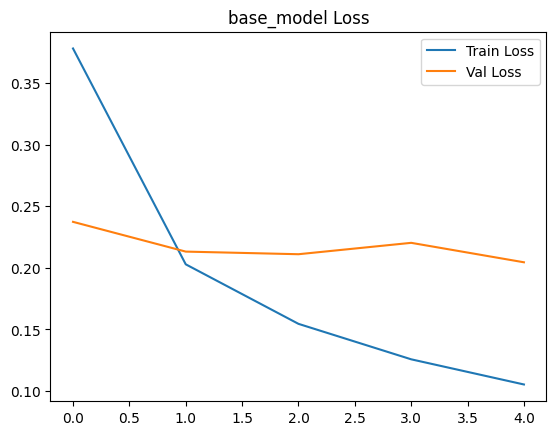

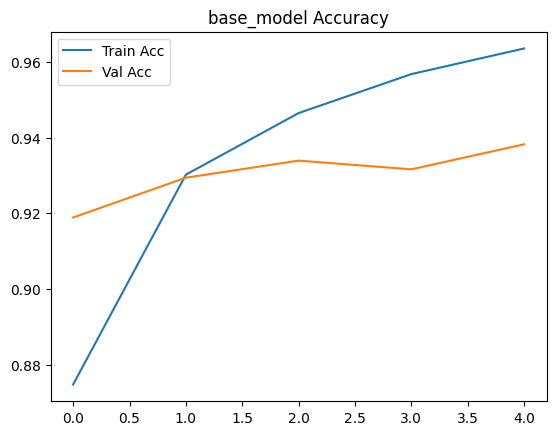

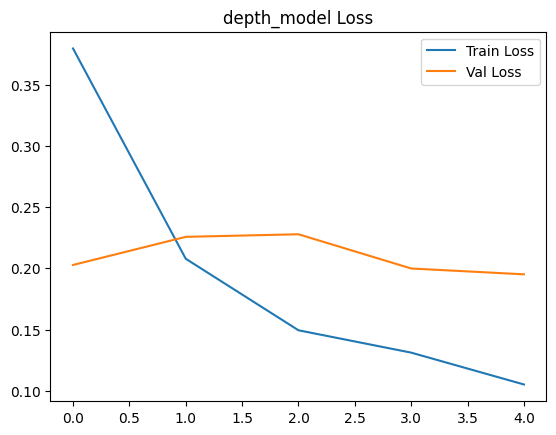

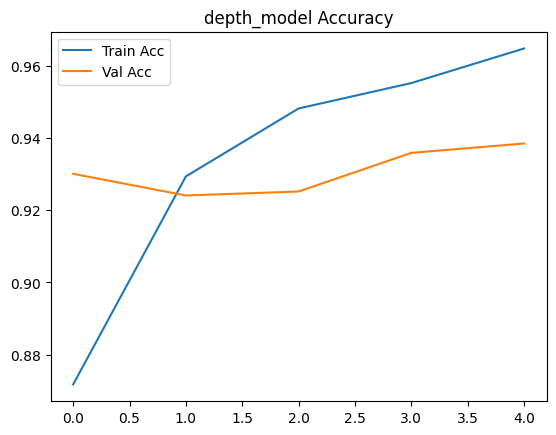

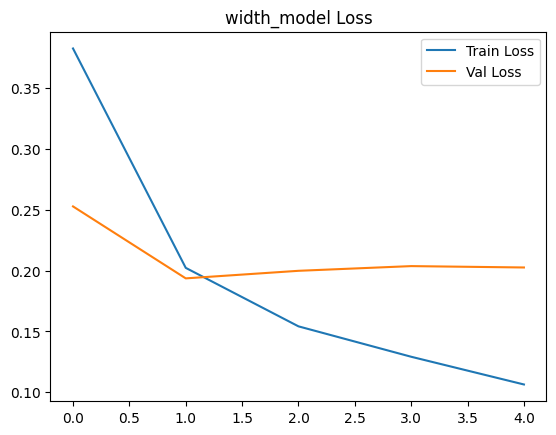

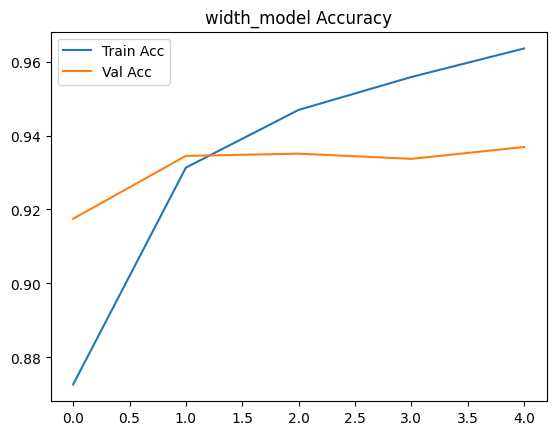

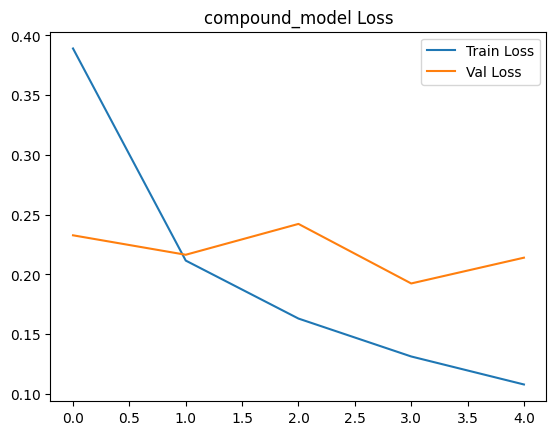

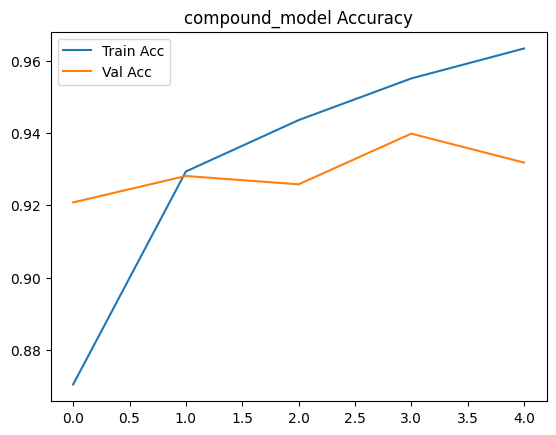

In [33]:
res_base = 224
res_depth = 256
res_width = 256
res_comp = 300

# Base model
model_base = get_base_model()
train_loader, test_loader = get_cifar10_loaders(res_base)
run_experiment(model_base, train_loader, test_loader, model_name="base_model", resolution=res_base)

# Depth-only
model_depth = depth_only_model(scale=1.2)
train_loader, test_loader = get_cifar10_loaders(res_depth)
run_experiment(model_depth, train_loader, test_loader, model_name="depth_model", resolution=res_depth)

# Width-only
model_width = width_only_model(scale=1.1)
train_loader, test_loader = get_cifar10_loaders(res_width)
run_experiment(model_width, train_loader, test_loader, model_name="width_model", resolution=res_width)

# Compound (depth + width)
model_comp = compound_model(scale_d=1.2, scale_w=1.1)
train_loader, test_loader = get_cifar10_loaders(res_comp)
run_experiment(model_comp, train_loader, test_loader, model_name="compound_model", resolution=res_comp)

Step 10: Compare FLOPs/Parameters across Models

In [34]:
print("\n[Base] EfficientNet-B0:")
measure_flops(get_base_model(), input_res=res_base)

print("\n[Depth-Only] Scaled:")
measure_flops(depth_only_model(scale=1.2), input_res=res_depth)

print("\n[Width-Only] Scaled:")
measure_flops(width_only_model(scale=1.1), input_res=res_width)

print("\n[Compound] Scaled:")
measure_flops(compound_model(scale_d=1.2, scale_w=1.1), input_res=res_comp)


[Base] EfficientNet-B0:
FLOPs: 408.93 MMac
Params: 4.02 M

[Depth-Only] Scaled:
FLOPs: 533.91 MMac
Params: 4.02 M

[Width-Only] Scaled:
FLOPs: 578.4 MMac
Params: 4.02 M

[Compound] Scaled:
FLOPs: 838.07 MMac
Params: 4.02 M
